# Introduction

In this notebook, we will visualize the uncertainty of the shooting range of a cannon by using a visualization technique called hypothetical outcome plots. Towards that end, we will create an animation that cycles through different possible cannonball trajectories. In this way, we are able to let the audiences experience the analysis uncertainty, thus making uncertainty visualization intuitive, effective, and fun.

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
np.random.seed(42)

# Problem settings

### Physical background

In this case study, we consider a projectile motion problem and we are interested in calculating the shooting range $R$ of a cannon. For demonstration purpose, we choose a rather simple physical model to describe the trajectary of the cannonball, where the shooting range $R$ is calculated by:

\begin{equation}
R = \frac{v_0^2 sin 2 \theta}{g},
\end{equation}

where $v_0$ is the initial velocity of the cannonball, $\theta$ is the shooting angle, and $g=9.8m/s^2$ is the gravity acceleration. An illustration of the current problem is shown below.

<img src="Illustration_cannon.png" width=500 height=300 />

### Uncertainty analysis

Suppose that we are not sure about the values of $v_0$ and $\theta$, as they can be influenced by randomness in practice. To describe their uncertainty, we assign a probability distribution for $v_0$ and $\theta$, respectively. Specifically, we assume:

- $v_0$ follows a normal distribution, i.e., $v_0 \sim \mathcal{N}(150,5^2)$. This distribution indicates that the mean value of $v_0$ is $150m/s$ and the standard deviation value of $v_0$ is $5m/s$;

- $\theta$ follows a uniform distribution, i.e., $\theta \sim \mathcal{U}(40,50)$. This distribution indicates that $\theta$ can take any value between $40^{o}$ and $50^{o}$ with equal probability.

Due to the uncertainty embedded in the model parameters ($v_0$ and $\theta$), the prediction of shooting range $R$ will also be uncertain. To quantify the uncertainty of $R$ calculation, we can perform Monte Carlo simulations 

### 1. Monte Carlo simulations

First of all, let's perform Monte Carlo simulations to quantify the uncertainty of $R$ calculations. If you want to learn more about Monte Carlo approach and forward uncertainty propagation, feel free to check out my article on medium:

[Using Monte Carlo To Quantify The Model Prediction Error](https://towardsdatascience.com/how-to-quantify-the-prediction-error-made-by-my-model-db4705910173)

In [30]:
# Generate input samples
MC_sample_num = 1000
v0 = np.random.normal(loc=150, scale=5, size=MC_sample_num)
theta = 10*np.random.rand(MC_sample_num)+40
g = 9.8

In [31]:
# Monte Carlo simulations
R = []
for i in range(MC_sample_num):
    R.append(v0[i]**2*np.sin(2*theta[i]/180*np.pi)/g)

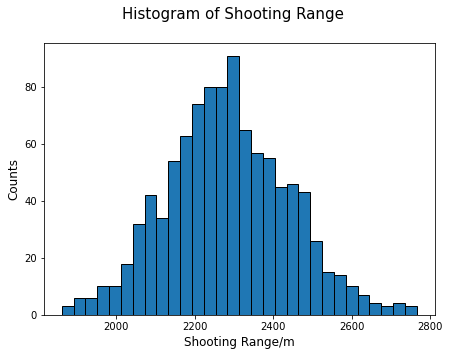

In [32]:
# Post processing
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(R, bins=30, edgecolor='black')
fig.suptitle('Histogram of Shooting Range', fontsize=15)
ax.set_xlabel('Shooting Range/m', fontsize=12)
ax.set_ylabel('Counts', fontsize=12);

In [24]:
# Define trajectory calculation function
def traj_cal(v0, theta, g, time_step=10):
    '''Calculate the cannonball trajectory
    Inputs:
        v0 --> initial velocity of the cannonball
        theta --> shooting angle (in degree)
        g --> gravity acceleration
        time_step --> time discretization
    Outputs:
        coor_X --> X coordinates of the cannonball
        coor_Y --> Y coordinates of the cannonball'''
    
    # Time for the cannonball to reach maximum height
    t_c = v0*np.sin(theta/180*np.pi)/g
    
    # Time discretization
    t = np.linspace(start=0, stop=2*t_c, num=time_step)
    coor_X, coor_Y = [], []
    
    # Calculate trajectory
    for time in t:
        coor_X.append(v0*np.cos(theta/180*np.pi)*time)
        if time <= t_c:
            coor_Y.append(v0*np.sin(theta/180*np.pi)*time-0.5*g*time**2)
        else:
            coor_Y.append(v0*np.sin(theta/180*np.pi)*t_c-0.5*g*t_c**2-0.5*g*(time-t_c)**2)
    
    return coor_X, coor_Y